## Exercício em grupo

Cada grupo deve desenvolver uma rede neural MLP para classificar o dataset Kuzushiji-MNIST. O objetivo é conseguir a melhor acurácia no conjunto de teste.

Sugestões:

- Testar diferentes configurações, como número de camadas escondidas e neurônios por camadas;
- Testar como funciona com ou sem dropout;
- Testar diferentes otimizadores (não apenas SGD) e diferentes valores de taxa de aprendizado;
- Testar possiveis transformações no dataset;
- Testar diferente números de épocas.

Apresentação:

- Carregar o modelo treinado e executar o passo de inferência sobre o conjunto de testes;
- Mostrar gráfico de convergência durante as épocas, considerando o conjunto de treinamento e o conjunto de testes;
- Mostrar matriz de confusão, acurácia, e demais métricas que acharem necessárias.




-----------------------------------------------------------------------------

In [10]:
# for better image plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np

import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict

In [36]:
from torch.autograd import Variable

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST" or "KMNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "FashionMNIST":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

# Criando o modelo e uma função para simular diferentes cenários
### 1) NeuralNetwork Class 
- herda de `nn.Module`
- `__init__` define as camadas: input, ocultas e output
- metodo `forward`: recebe x, achata o tensor, passa na funcão de ativação (ReLU) para cada camada. A saída é obtida passando a `log_softmax` (dim=1, ou seja, pega por coluna sendo um de cada classe).
### 2) NeuralNetwork_reg Class
- herda de `nn.Module`
- `__init__` define as camadas: input, ocultas e output; regularização `dropout` com probabilidade de 20% de desativar os neurônios (esse procedimento ajuda a balancear os pesos).
- metodo `forward`: recebe x, achata o tensor, passa na funcão de ativação (ReLU), e depois no `dropout`, isso para cada camada. A saída também é obtida passando a `log_softmax` (dim=1).

## Criando uma função `model_pipeline` para avaliar diferentes cenários
1) Tipos de TRASNFORMS usados: 
    1) `ToTensor()`: recebe uma imagem em formato **PIL** e tranforma em um tensor 
    
    2) `RandomHorizontalFlip`
    
     ![RandomHorizontalFlip](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_020.png)
     
    3) `RandomRotation` 
    
     ![RandomRotation](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_009.png)
     
    4) `RandomPerspective`
    
     ![RandomPerspective](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_008.png)
     
2) Modelos
    1) **SEM** regularização, passando a instancia da classe `NeuralNetwork`
    2) **COM** regularização, passando a instancia da classe `NeuralNetwork_reg`
3) Função Loss
    1) This criterion combines LogSoftmax and NLLLoss in one single class: `"cross"`
    2) Negative log likelihood loss with Poisson distribution of target: `"poiss"`
    3) Gaussian negative log likelihood loss: `"gauss"`
    4) The negative log likelihood loss: `"nll"`
4) Otimizador:
 Optimizer functions: passed as a string. Options:
     1) Implements Adam algorithm: `"adam"`
     2) Implements Adamax algorithm (a variant of Adam based on infinity norm): `"adamax"`
     3) Implements Averaged Stochastic Gradient Descent: `"asgd"`
5) Tamanho do set de validação: `validation_size`: default = 0.2
6) `batch_size`: default = 200
7) `epochs`: default = 5
8) `lr_rate`: default = 0.002

# Definindo as classes

In [6]:
from torch import nn 
# classe sem regularizaçao

class NeuralNetwork(nn.Module):
    def __init__(self): 
        super().__init__()
        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98 )
        self.fc4 = nn.Linear( 98, 64)
        self.fc5 = nn.Linear(64, 10)
        
    def forward(self, x):
        # certificar que o tensor com as imagens foi 'achatado'
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

In [7]:
# Classe com regularizaçao

class NeuralNetwork_reg(nn.Module):
    def __init__(self): 
        super().__init__()
        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 64)
        self.fc5 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        # certificar que o tensor com as imagens foi 'achatado'
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

# Alguns testes
## 5 épocas:

* Adam:

   - Epoch: 1/5..  Training Loss: 0.493..  Test Loss: 0.633..  Test Accuracy: 0.812
   - Epoch: 2/5..  Training Loss: 0.260..  Test Loss: 0.487..  Test Accuracy: 0.859
   - Epoch: 3/5..  Training Loss: 0.193..  Test Loss: 0.466..  Test Accuracy: 0.870
   - Epoch: 4/5..  Training Loss: 0.168..  Test Loss: 0.633..  Test Accuracy: 0.848
   - Epoch: 5/5..  Training Loss: 0.147..  Test Loss: 0.486..  Test Accuracy: 0.875

* Adamax:

   - Epoch: 1/5..  Training Loss: 0.513..  Test Loss: 0.607..  Test Accuracy: 0.811
   - Epoch: 2/5..  Training Loss: 0.234..  Test Loss: 0.477..  Test Accuracy: 0.857
   - Epoch: 3/5..  Training Loss: 0.164..  Test Loss: 0.506..  Test Accuracy: 0.854
   - Epoch: 4/5..  Training Loss: 0.122..  Test Loss: 0.391..  Test Accuracy: 0.892
   - Epoch: 5/5..  Training Loss: 0.094..  Test Loss: 0.449..  Test Accuracy: 0.882


## 10 épocas:

* Adamax:

    - Epoch: 1/10..  Training Loss: 0.075..  Test Loss: 0.385..  Test Accuracy: 0.899
    - Epoch: 2/10..  Training Loss: 0.057..  Test Loss: 0.423..  Test Accuracy: 0.901
    - Epoch: 3/10..  Training Loss: 0.048..  Test Loss: 0.432..  Test Accuracy: 0.907
    - Epoch: 4/10..  Training Loss: 0.039..  Test Loss: 0.490..  Test Accuracy: 0.904
    - Epoch: 5/10..  Training Loss: 0.034..  Test Loss: 0.431..  Test Accuracy: 0.907
    - Epoch: 6/10..  Training Loss: 0.026..  Test Loss: 0.476..  Test Accuracy: 0.908
    - Epoch: 7/10..  Training Loss: 0.022..  Test Loss: 0.482..  Test Accuracy: 0.910
    - Epoch: 8/10..  Training Loss: 0.018..  Test Loss: 0.486..  Test Accuracy: 0.915
    - Epoch: 9/10..  Training Loss: 0.018..  Test Loss: 0.494..  Test Accuracy: 0.916
    - Epoch: 10/10..  Training Loss: 0.014..  Test Loss: 0.565..  Test Accuracy: 0.911

# Definindo a função

In [43]:
def model_pipeline(dataset = 'KMNIST', horizontal_flip=False, flip_percentage=0.5,              # transformations
                   random_rotation=False, rotation_degree=20, 
                   random_perspective=False, distortion_scale=0.6, 
                   validation_size=0.2, reg=False, loss = 'cross', optimizer = 'adam',   # model parameters
                   batch_size=200, epochs = 5, lr_rate=0.002):                            
    
    """This function builds and trains a neural network model.
    ---> dataset: downloads the training and test sets dependind on the dataset passed as a string.
         - options: 'KMNIST', 'MNIST', 'FashionMNIST'; (). 
    ---> Transforms:
        1) horizontal_flip: True or False (default = False).
        - flip_percentage: probability of the image being flipped (default = 0.5).
        2) random_rotation: True or False (default = False).
        - rotation_degree: degree that the image will rotate (default = 20).
        3) random_perspective: True or False (default = False).
        - distortion_scale: argument to control the degree of distortion and ranges from 0 to 1 (default = 0.6).
   ---> Model, Loss and Optimizer:
        4) validation_size: size of the train samples that will be used to validate the model (default = 0.2).
        5) reg: True or False (default = False)| If the model will be defined with or without regularization.
        6) Loss functions: passed as a string. Options: "cross", "poiss", "gauss", "nll".
        7) Optimizer functions: passed as a string. Options: "adam", "adamax", "asgd".
   ---> Other parameters:
        8) batch_size: number of batches to pass into the dataloader (default = 200).
        9) epochs: defining the number of epochs (default = 5).
        10) lr_rate: the rate that the SGD will learn and reduce the loss function (default = 0.002).
        """ 
    ### creating transform pipeline
    if horizontal_flip:
        transformations = transforms.Compose([transforms.RandomHorizontalFlip(flip_percentage)])
    if random_rotation:
        transformations = transforms.Compose([transforms.RandomRotation(rotation_degree)])
    if random_perspective:
        transformations = transforms.Compose([transforms.RandomPerspective(distortion_scale)])

    transformations = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))])
    
    ### Downloading the training and test data dependind on the dataset variable passed as a string
    if dataset == 'KMNIST':
        train_dataset = datasets.KMNIST('./data', download=True, train=True, transform=transformations)
        test_dataset = datasets.KMNIST('./data/', download=True, train=False, transform=transformations)
    elif dataset == 'MNIST':
        train_dataset = datasets.MNIST('./data', download=True, train=True, transform=transformations)
        test_dataset = datasets.MNIST('./data/', download=True, train=False, transform=transformations)
    elif dataset == 'FashionMNIST':
        train_dataset = datasets.FashionMNIST('./data', download=True, train=True, transform=transformations)
        test_dataset = datasets.FashionMNIST('./data/', download=True, train=False, transform=transformations)
    
    # Get the size of our train set
    training_size = len(train_dataset)

    # then, we create a list of indices from 0 to training size range
    indices = list(range(training_size))

    # Shuffling the indices
    np.random.shuffle(indices)

    # The shuffled index will split the validation and training datasets using numpy "floor" method:
    index_split = int(np.floor(training_size * validation_size))  # floor of the scalar `x` is the largest integer

    # Then, we get the training and validation set indices passing the index split 
    validation_indices, training_indices = indices[:index_split], indices[index_split:]

    # Using SubsetRandomSampler we sample elements randomly from a list of indices
    training_sample = SubsetRandomSampler(training_indices)
    validation_sample = SubsetRandomSampler(validation_indices)
   
    ### creating the data loader, passing the sampler created above
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sample)
    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=validation_sample)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    ### defining the model with or without regularization
    if reg:       # if True the model will be instantiated with regularization (dropout)
        model = NeuralNetwork_reg()
    elif reg == False:         # if False, the model won't have regularization
        model = NeuralNetwork()
        
    ### LOSS
    if loss == 'cross':
        criterion = nn.CrossEntropyLoss() 
    elif loss == 'poiss':
        criterion = nn.PoissonNLLLoss()
    elif loss == 'gauss':
        criterion = nn.GaussianNLLLoss()
    elif loss == 'nll':
        criterion = nn.NLLLoss()
    
    ### OPTIMIZER
    if optimizer == 'adam':    
        optimizer = optim.Adam(model.parameters(), lr=lr_rate)
    if optimizer == 'adamax': 
        optimizer = optim.Adamax(model.parameters(), lr=lr_rate)
    if optimizer == 'asgd': 
        optimizer = optim.ASGD(model.parameters(), lr=lr_rate)
    
    ### Training the NN
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0
        for image, label in train_loader:
            optimizer.zero_grad()
            log_ps = model(image)
            loss = criterion(log_ps, label)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        else:
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                model.eval()
                for image, label in test_loader:         
                    log_ps = model.forward(image)
                    prob = torch.exp(log_ps)
                    test_loss+= criterion(log_ps, label)
                    k_prob, k_class = prob.topk(1, dim=1)
                    equals = k_class == label.view(*k_class.shape)
                    accuracy+= torch.mean(equals.type(torch.FloatTensor))
            model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training Loss: {:.3f}...".format(train_losses[-1]),
              "Test Loss: {:.3f}...".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        
    ### Showing the image and the probability barplot   
    images, labels = next(iter(train_loader))

    img = images[0].view(1, 784)
    # gradient OFF
    with torch.no_grad():
        logps = model(img)

    # We need the exp to see the real predictions
    ps = torch.exp(logps)
    view_classify(img.view(1, 28, 28), ps, version=dataset)
    
    # Graph of train and test losses
    plt.plot(train_losses, label = 'Train Loss')
    plt.plot(test_losses, label = 'Test Loss')
    plt.legend()
    
    return (accuracy/len(test_loader)), train_losses, test_losses

In [51]:
model_pipeline(trainset, testset, horizontal_flip=True, flip_percentage=0.2, lr_rate=0.002)

Epoch: 1/5..  Training Loss: 0.610..  Test Loss: 0.619..  Test Accuracy: 0.805
Epoch: 2/5..  Training Loss: 0.257..  Test Loss: 0.508..  Test Accuracy: 0.850
Epoch: 3/5..  Training Loss: 0.179..  Test Loss: 0.464..  Test Accuracy: 0.861
Epoch: 4/5..  Training Loss: 0.141..  Test Loss: 0.479..  Test Accuracy: 0.865
Epoch: 5/5..  Training Loss: 0.114..  Test Loss: 0.433..  Test Accuracy: 0.880


tensor(0.8801)

In [52]:
model_pipeline(trainset, testset, random_rotation=True, rotation_degree=20, flip_percentage=0.2, lr_rate=0.002)

Epoch: 1/5..  Training Loss: 0.624..  Test Loss: 0.660..  Test Accuracy: 0.794
Epoch: 2/5..  Training Loss: 0.250..  Test Loss: 0.510..  Test Accuracy: 0.842
Epoch: 3/5..  Training Loss: 0.179..  Test Loss: 0.449..  Test Accuracy: 0.865
Epoch: 4/5..  Training Loss: 0.140..  Test Loss: 0.473..  Test Accuracy: 0.864
Epoch: 5/5..  Training Loss: 0.109..  Test Loss: 0.451..  Test Accuracy: 0.881


tensor(0.8813)

In [53]:
model_pipeline(trainset, testset, random_rotation=True, rotation_degree=90, flip_percentage=0.2, lr_rate=0.002)

Epoch: 1/5..  Training Loss: 0.630..  Test Loss: 0.696..  Test Accuracy: 0.782
Epoch: 2/5..  Training Loss: 0.262..  Test Loss: 0.489..  Test Accuracy: 0.855
Epoch: 3/5..  Training Loss: 0.179..  Test Loss: 0.482..  Test Accuracy: 0.860
Epoch: 4/5..  Training Loss: 0.143..  Test Loss: 0.443..  Test Accuracy: 0.875
Epoch: 5/5..  Training Loss: 0.114..  Test Loss: 0.446..  Test Accuracy: 0.883


tensor(0.8828)

In [55]:
model_pipeline(trainset, testset, lr_rate=0.005)

Epoch: 1/5..  Training Loss: 0.600..  Test Loss: 0.645..  Test Accuracy: 0.803
Epoch: 2/5..  Training Loss: 0.274..  Test Loss: 0.561..  Test Accuracy: 0.831
Epoch: 3/5..  Training Loss: 0.202..  Test Loss: 0.523..  Test Accuracy: 0.856
Epoch: 4/5..  Training Loss: 0.164..  Test Loss: 0.539..  Test Accuracy: 0.852
Epoch: 5/5..  Training Loss: 0.141..  Test Loss: 0.464..  Test Accuracy: 0.876


tensor(0.8761)

In [56]:
model_pipeline(trainset, testset, loss='nll', lr_rate=0.002)

Epoch: 1/5..  Training Loss: 0.625..  Test Loss: 0.663..  Test Accuracy: 0.787
Epoch: 2/5..  Training Loss: 0.267..  Test Loss: 0.486..  Test Accuracy: 0.857
Epoch: 3/5..  Training Loss: 0.187..  Test Loss: 0.506..  Test Accuracy: 0.855
Epoch: 4/5..  Training Loss: 0.146..  Test Loss: 0.464..  Test Accuracy: 0.874
Epoch: 5/5..  Training Loss: 0.117..  Test Loss: 0.445..  Test Accuracy: 0.879


tensor(0.8788)

In [57]:
model_pipeline(trainset, testset, loss='nll', lr_rate=0.005)

Epoch: 1/5..  Training Loss: 0.592..  Test Loss: 0.658..  Test Accuracy: 0.798
Epoch: 2/5..  Training Loss: 0.288..  Test Loss: 0.591..  Test Accuracy: 0.824
Epoch: 3/5..  Training Loss: 0.207..  Test Loss: 0.488..  Test Accuracy: 0.861
Epoch: 4/5..  Training Loss: 0.168..  Test Loss: 0.476..  Test Accuracy: 0.866
Epoch: 5/5..  Training Loss: 0.145..  Test Loss: 0.444..  Test Accuracy: 0.880


tensor(0.8797)

In [59]:
model_pipeline(trainset, testset, loss='nll', optimizer= 'adamax', lr_rate=0.005)

Epoch: 1/5..  Training Loss: 0.658..  Test Loss: 0.712..  Test Accuracy: 0.773
Epoch: 2/5..  Training Loss: 0.275..  Test Loss: 0.535..  Test Accuracy: 0.844
Epoch: 3/5..  Training Loss: 0.193..  Test Loss: 0.481..  Test Accuracy: 0.860
Epoch: 4/5..  Training Loss: 0.148..  Test Loss: 0.448..  Test Accuracy: 0.871
Epoch: 5/5..  Training Loss: 0.115..  Test Loss: 0.430..  Test Accuracy: 0.882


tensor(0.8823)

In [60]:
model_pipeline(trainset, testset, loss='nll', optimizer= 'adamax', lr_rate=0.002)

Epoch: 1/5..  Training Loss: 0.789..  Test Loss: 0.819..  Test Accuracy: 0.742
Epoch: 2/5..  Training Loss: 0.354..  Test Loss: 0.637..  Test Accuracy: 0.807
Epoch: 3/5..  Training Loss: 0.251..  Test Loss: 0.544..  Test Accuracy: 0.833
Epoch: 4/5..  Training Loss: 0.190..  Test Loss: 0.527..  Test Accuracy: 0.837
Epoch: 5/5..  Training Loss: 0.149..  Test Loss: 0.480..  Test Accuracy: 0.864


tensor(0.8640)

In [61]:
model_pipeline(trainset, testset, horizontal_flip=True, flip_percentage=0.5, loss='nll', optimizer= 'adamax', lr_rate=0.002)

Epoch: 1/5..  Training Loss: 0.757..  Test Loss: 0.794..  Test Accuracy: 0.745
Epoch: 2/5..  Training Loss: 0.337..  Test Loss: 0.650..  Test Accuracy: 0.799
Epoch: 3/5..  Training Loss: 0.243..  Test Loss: 0.483..  Test Accuracy: 0.852
Epoch: 4/5..  Training Loss: 0.178..  Test Loss: 0.469..  Test Accuracy: 0.861
Epoch: 5/5..  Training Loss: 0.143..  Test Loss: 0.477..  Test Accuracy: 0.859


tensor(0.8586)

In [62]:
model_pipeline(trainset, testset, horizontal_flip=True, flip_percentage=0.5, loss='cross', optimizer= 'adam', lr_rate=0.002)

Epoch: 1/5..  Training Loss: 0.626..  Test Loss: 0.650..  Test Accuracy: 0.788
Epoch: 2/5..  Training Loss: 0.266..  Test Loss: 0.519..  Test Accuracy: 0.841
Epoch: 3/5..  Training Loss: 0.191..  Test Loss: 0.478..  Test Accuracy: 0.858
Epoch: 4/5..  Training Loss: 0.146..  Test Loss: 0.403..  Test Accuracy: 0.884
Epoch: 5/5..  Training Loss: 0.120..  Test Loss: 0.449..  Test Accuracy: 0.873


tensor(0.8728)

## Alterando a função para retornar também a figura e o gráfico mostrando as probabilidades de cada classe

- Horizontal Flip

Epoch: 1/5... Training Loss: 0.630... Test Loss: 0.653... Test Accuracy: 0.796
Epoch: 2/5... Training Loss: 0.264... Test Loss: 0.531... Test Accuracy: 0.845
Epoch: 3/5... Training Loss: 0.187... Test Loss: 0.482... Test Accuracy: 0.857
Epoch: 4/5... Training Loss: 0.148... Test Loss: 0.418... Test Accuracy: 0.881
Epoch: 5/5... Training Loss: 0.110... Test Loss: 0.433... Test Accuracy: 0.881


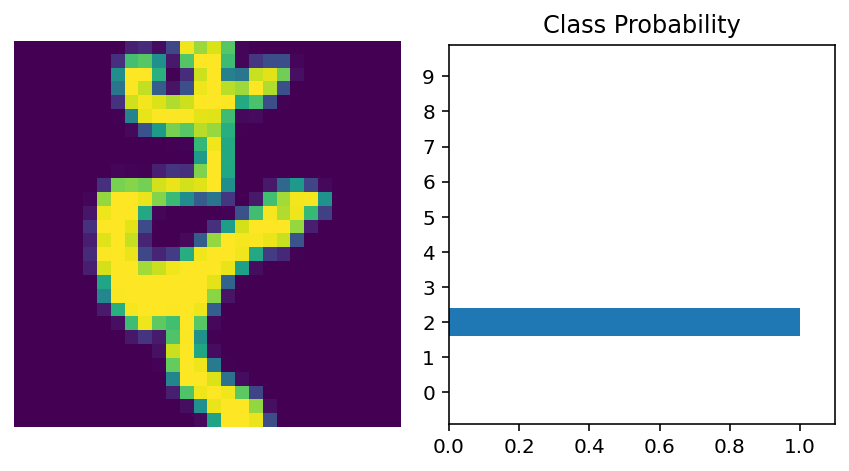

In [16]:
## Sem regularizacao
acc, train_loss, test_loss = model_pipeline(dataset='KMNIST', horizontal_flip=True, flip_percentage=0.5, loss='nll')

Epoch: 1/5... Training Loss: 0.755... Test Loss: 0.742... Test Accuracy: 0.769
Epoch: 2/5... Training Loss: 0.365... Test Loss: 0.563... Test Accuracy: 0.827
Epoch: 3/5... Training Loss: 0.292... Test Loss: 0.509... Test Accuracy: 0.847
Epoch: 4/5... Training Loss: 0.253... Test Loss: 0.435... Test Accuracy: 0.874
Epoch: 5/5... Training Loss: 0.217... Test Loss: 0.480... Test Accuracy: 0.867


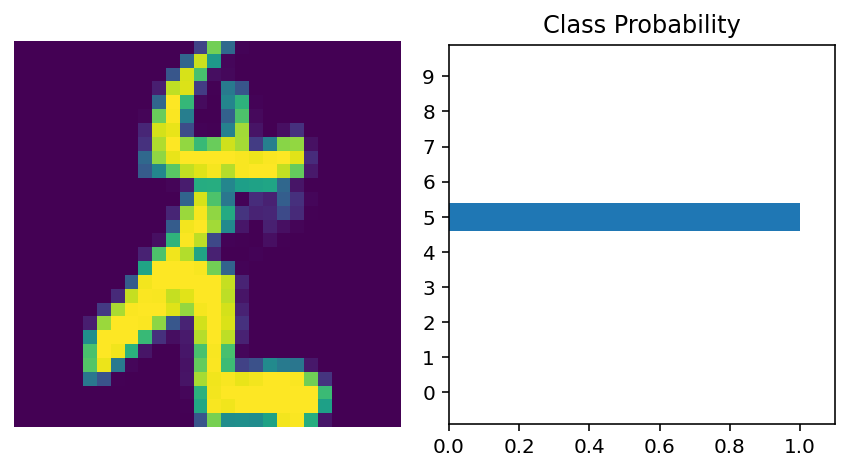

In [17]:
## Com regularizacao
acc, train_loss, test_loss = model_pipeline(dataset='KMNIST', horizontal_flip=True, reg=True, flip_percentage=0.5, loss='nll')

- Random Rotation:

Epoch: 1/5... Training Loss: 0.609... Test Loss: 0.659... Test Accuracy: 0.794
Epoch: 2/5... Training Loss: 0.252... Test Loss: 0.489... Test Accuracy: 0.850
Epoch: 3/5... Training Loss: 0.179... Test Loss: 0.470... Test Accuracy: 0.863
Epoch: 4/5... Training Loss: 0.133... Test Loss: 0.427... Test Accuracy: 0.883
Epoch: 5/5... Training Loss: 0.112... Test Loss: 0.463... Test Accuracy: 0.877


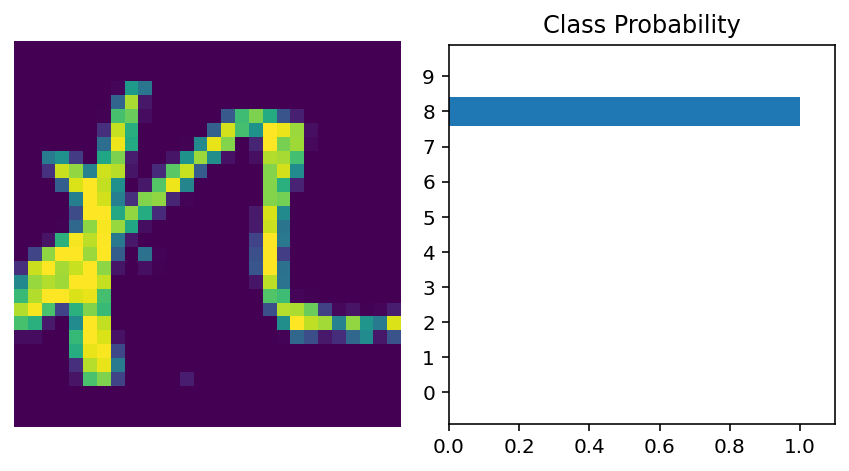

In [18]:
## Sem regularizacao
acc, train_loss, test_loss = model_pipeline(dataset='KMNIST', random_rotation=True, rotation_degree=45, loss='cross')

Epoch: 1/5... Training Loss: 0.750... Test Loss: 0.672... Test Accuracy: 0.790
Epoch: 2/5... Training Loss: 0.379... Test Loss: 0.613... Test Accuracy: 0.818
Epoch: 3/5... Training Loss: 0.292... Test Loss: 0.542... Test Accuracy: 0.846
Epoch: 4/5... Training Loss: 0.251... Test Loss: 0.486... Test Accuracy: 0.859
Epoch: 5/5... Training Loss: 0.213... Test Loss: 0.473... Test Accuracy: 0.862


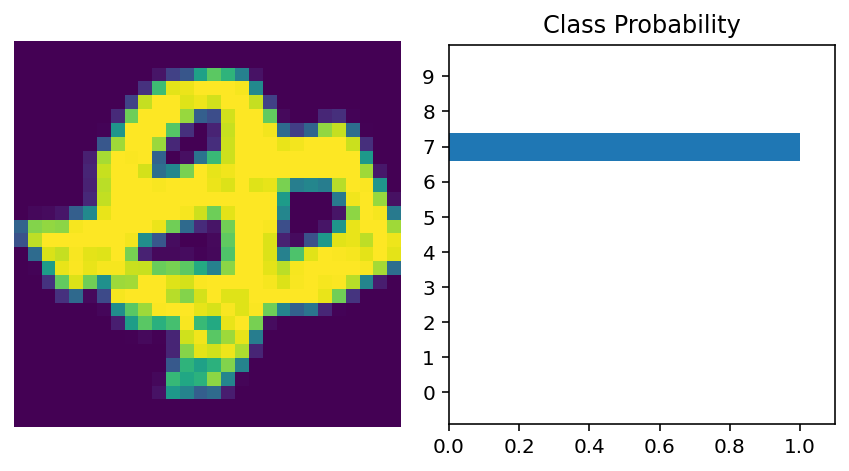

In [19]:
## Com regularizacao
acc, train_loss, test_loss = model_pipeline(dataset='KMNIST', random_rotation=True, rotation_degree=45, reg=True, loss='cross')

- Random Perspective:

Epoch: 1/5... Training Loss: 0.617... Test Loss: 0.680... Test Accuracy: 0.793
Epoch: 2/5... Training Loss: 0.257... Test Loss: 0.584... Test Accuracy: 0.823
Epoch: 3/5... Training Loss: 0.183... Test Loss: 0.471... Test Accuracy: 0.860
Epoch: 4/5... Training Loss: 0.136... Test Loss: 0.495... Test Accuracy: 0.857
Epoch: 5/5... Training Loss: 0.110... Test Loss: 0.449... Test Accuracy: 0.881


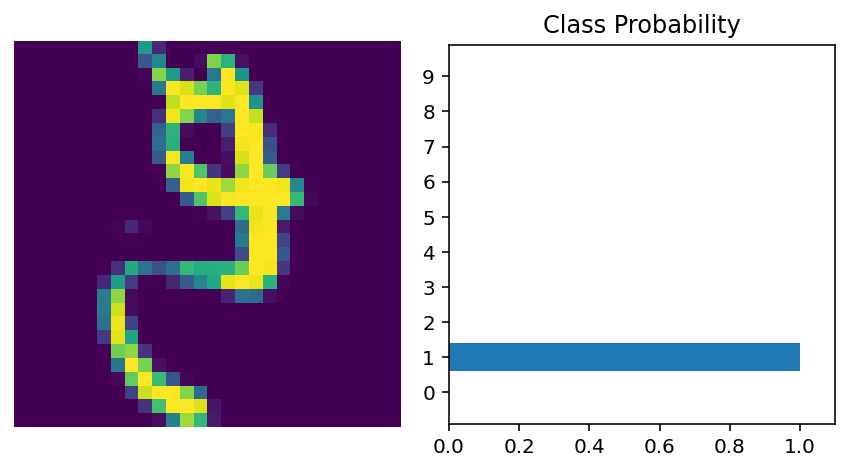

In [20]:
## Sem regularizacao
acc, train_loss, test_loss = model_pipeline(dataset='KMNIST', random_perspective=True, distortion_scale=0.8, loss='nll')

Epoch: 1/5... Training Loss: 0.764... Test Loss: 0.707... Test Accuracy: 0.779
Epoch: 2/5... Training Loss: 0.377... Test Loss: 0.602... Test Accuracy: 0.821
Epoch: 3/5... Training Loss: 0.301... Test Loss: 0.515... Test Accuracy: 0.845
Epoch: 4/5... Training Loss: 0.252... Test Loss: 0.498... Test Accuracy: 0.858
Epoch: 5/5... Training Loss: 0.222... Test Loss: 0.498... Test Accuracy: 0.858


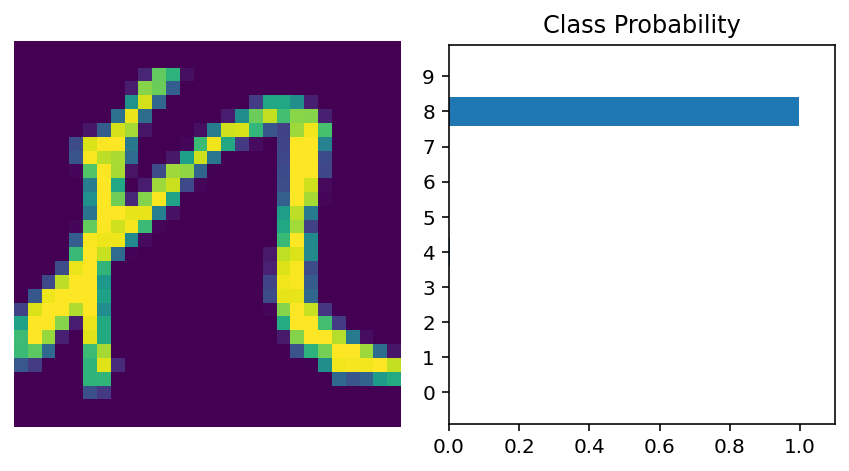

In [21]:
## Com regularizacao
acc, train_loss, test_loss = model_pipeline(dataset='KMNIST', random_perspective=True, distortion_scale=0.8, reg=True, loss='nll')

## USANDO REGULARIZAÇÃO (dropout)
#### - tivemos uma acurácia mais baixa e o training loss diminuiu menos tanto com as epochs

## Transforms
#### - Horizontal Flip e Random Perspective deram resultados de acurácia (88.1%) mais altos que Random Rotation

## Usando o melhor resultados para testar a função Loss 'CrossEntropyLoss'
#### - 87.7%

Epoch: 1/5... Training Loss: 0.640... Test Loss: 0.695... Test Accuracy: 0.780
Epoch: 2/5... Training Loss: 0.264... Test Loss: 0.521... Test Accuracy: 0.841
Epoch: 3/5... Training Loss: 0.194... Test Loss: 0.454... Test Accuracy: 0.868
Epoch: 4/5... Training Loss: 0.145... Test Loss: 0.454... Test Accuracy: 0.877
Epoch: 5/5... Training Loss: 0.116... Test Loss: 0.443... Test Accuracy: 0.877


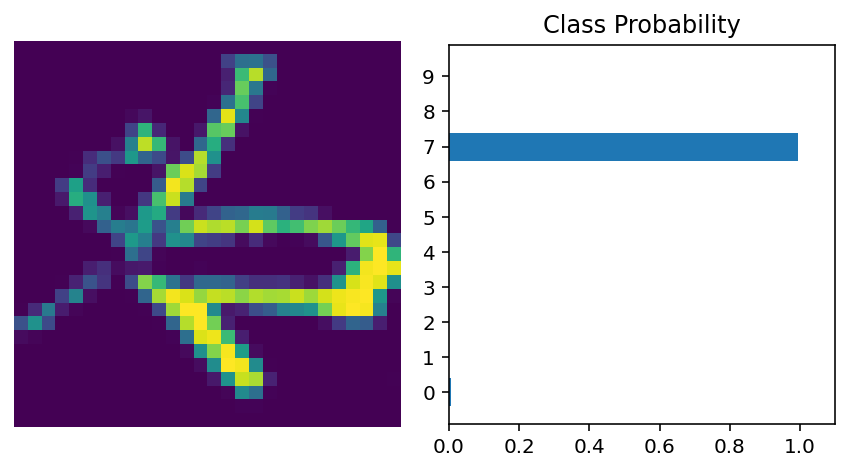

In [22]:
## Testando Função LOSS 'Cross': 
acc, train_loss, test_loss = model_pipeline(dataset='KMNIST', random_perspective=True, distortion_scale=0.8, loss='cross')

Epoch: 1/5... Training Loss: 0.759... Test Loss: 0.804... Test Accuracy: 0.745
Epoch: 2/5... Training Loss: 0.349... Test Loss: 0.659... Test Accuracy: 0.798
Epoch: 3/5... Training Loss: 0.248... Test Loss: 0.531... Test Accuracy: 0.836
Epoch: 4/5... Training Loss: 0.189... Test Loss: 0.451... Test Accuracy: 0.866
Epoch: 5/5... Training Loss: 0.146... Test Loss: 0.453... Test Accuracy: 0.869


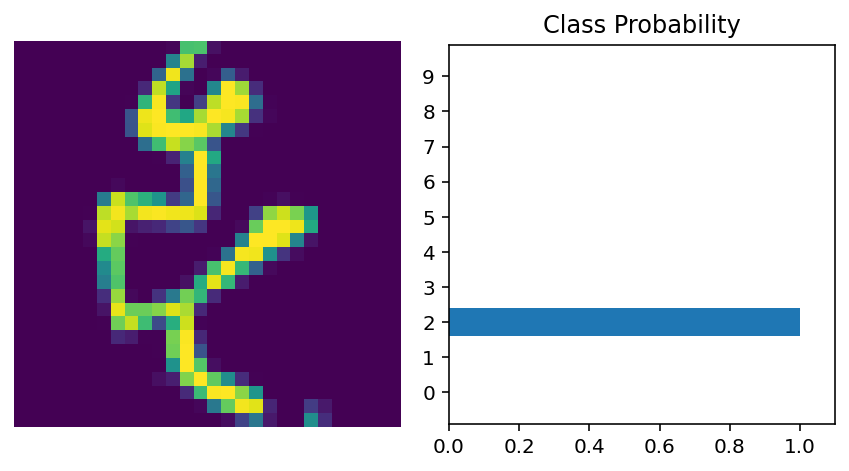

In [33]:
## Testando Função OPTIM 'adamax': 
acc, train_loss, test_loss = model_pipeline(dataset='KMNIST', random_perspective=True, distortion_scale=0.8, loss='nll', optimizer='adamax')

## Testando diferentes Learning rate

Learning rate:0.001

Epoch: 1/5... Training Loss: 0.890... Test Loss: 0.897... Test Accuracy: 0.714
Epoch: 2/5... Training Loss: 0.429... Test Loss: 0.713... Test Accuracy: 0.778
Epoch: 3/5... Training Loss: 0.322... Test Loss: 0.607... Test Accuracy: 0.808
Epoch: 4/5... Training Loss: 0.259... Test Loss: 0.575... Test Accuracy: 0.822
Epoch: 5/5... Training Loss: 0.214... Test Loss: 0.509... Test Accuracy: 0.845



Learning rate:0.004

Epoch: 1/5... Training Loss: 0.707... Test Loss: 0.792... Test Accuracy: 0.749
Epoch: 2/5... Training Loss: 0.306... Test Loss: 0.560... Test Accuracy: 0.824
Epoch: 3/5... Training Loss: 0.214... Test Loss: 0.511... Test Accuracy: 0.846
Epoch: 4/5... Training Loss: 0.162... Test Loss: 0.423... Test Accuracy: 0.875
Epoch: 5/5... Training Loss: 0.126... Test Loss: 0.462... Test Accuracy: 0.874



Learning rate:0.007

Epoch: 1/5... Training Loss: 0.610... Test Loss: 0.635... Test Accuracy: 0.801
Epoch: 2/5... Training Loss: 0.251... Test Loss: 0.479... Test

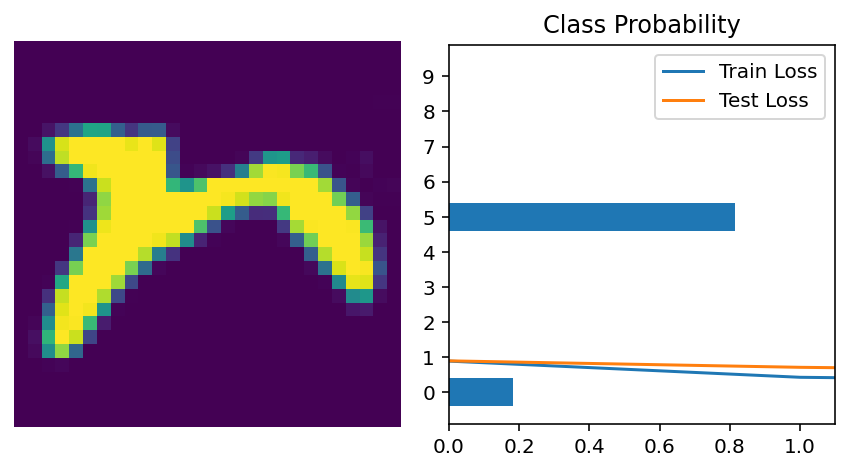

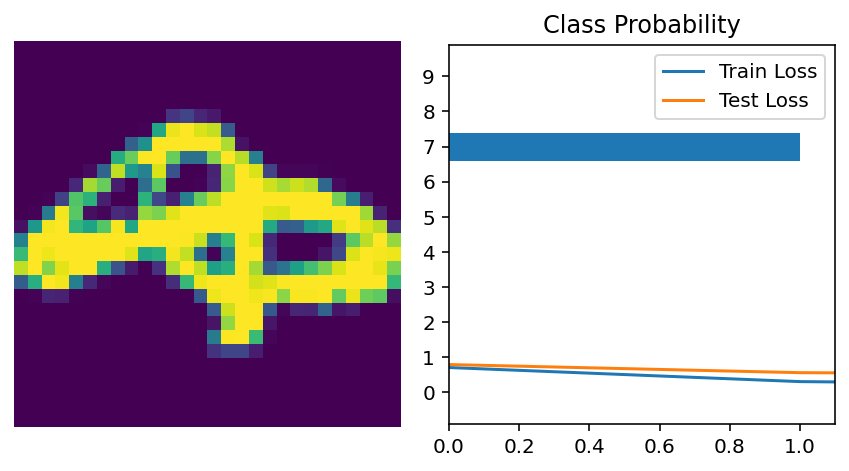

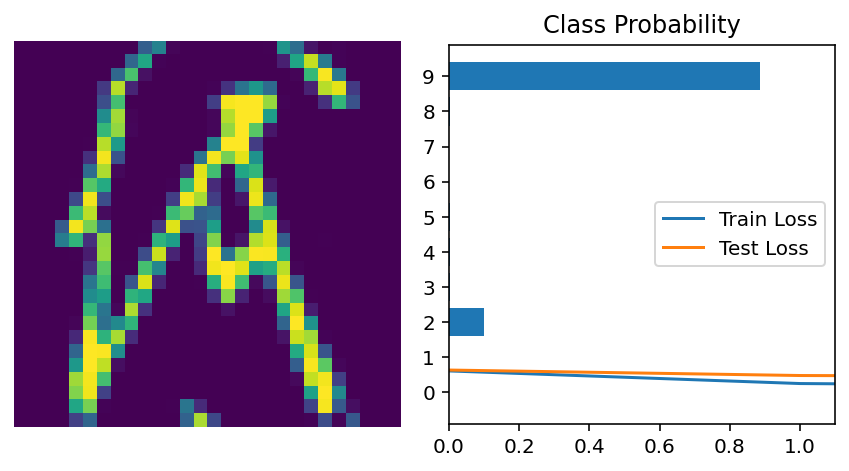

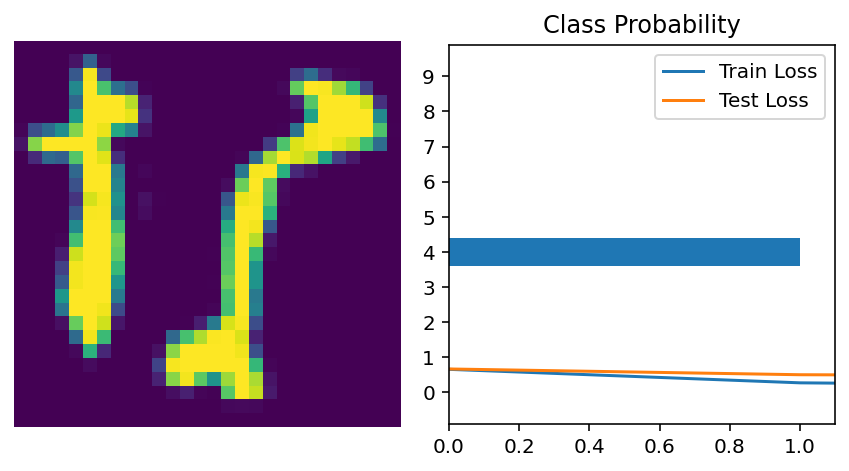

In [45]:
## aumentando a Learning rate: 
for i in np.arange(0.001, 0.01, 0.003):
    print(f'Learning rate:{i}\n')
    acc, train_loss, test_loss = model_pipeline(dataset='KMNIST', random_perspective=True, distortion_scale=0.8, optimizer='adamax', lr_rate=i)
    print('\n\n')

# Testando a funcao com outros datasets: FashionMNIST e MNIST

Epoch: 1/5... Training Loss: 0.594... Test Loss: 0.449... Test Accuracy: 0.840
Epoch: 2/5... Training Loss: 0.396... Test Loss: 0.405... Test Accuracy: 0.854
Epoch: 3/5... Training Loss: 0.356... Test Loss: 0.378... Test Accuracy: 0.862
Epoch: 4/5... Training Loss: 0.330... Test Loss: 0.439... Test Accuracy: 0.844
Epoch: 5/5... Training Loss: 0.315... Test Loss: 0.384... Test Accuracy: 0.864


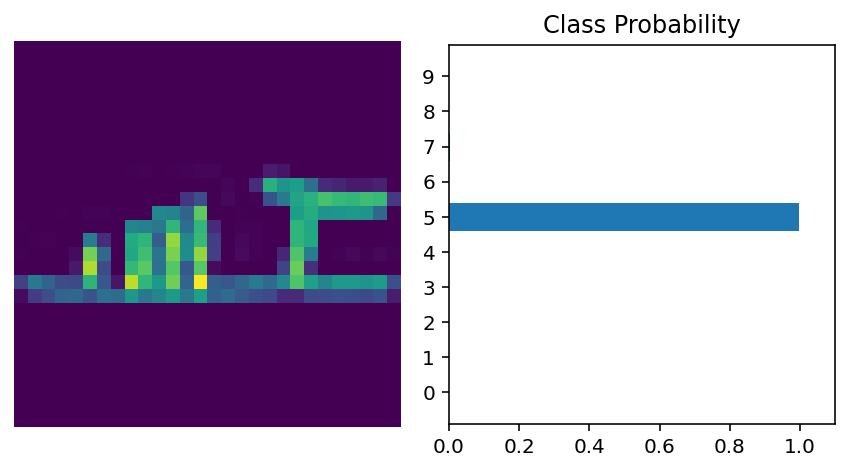

In [38]:
## Testando outro dataset 
acc, train_loss, test_loss = model_pipeline(dataset='FashionMNIST', random_perspective=True, distortion_scale=0.8, loss='nll')

Epoch: 1/5... Training Loss: 0.537... Test Loss: 0.229... Test Accuracy: 0.929
Epoch: 2/5... Training Loss: 0.196... Test Loss: 0.234... Test Accuracy: 0.923
Epoch: 3/5... Training Loss: 0.144... Test Loss: 0.145... Test Accuracy: 0.955
Epoch: 4/5... Training Loss: 0.115... Test Loss: 0.126... Test Accuracy: 0.962
Epoch: 5/5... Training Loss: 0.102... Test Loss: 0.111... Test Accuracy: 0.965


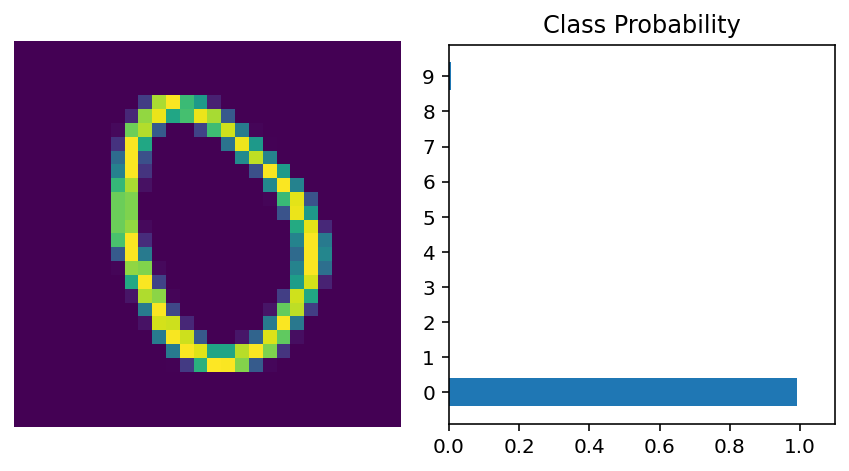

In [39]:
## Testando outro dataset 
acc, train_loss, test_loss = model_pipeline(dataset='MNIST', random_perspective=True, distortion_scale=0.5, loss='nll')